/Users/ludovicamontani/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-15-111d09f19d32>:41: RuntimeWarning: overflow encountered in square
  sumofsquares_N = np.sum((N_exp - N_predicted) ** 2)
/Users/ludovicamontani/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-15-111d09f19d32>:16: RuntimeWarning: overflow encountered in double_scalars
  dQ = (uQ - kQP) * x[1] + kPQ * x[0]
<ipython-input-15-111d09f19d32>:16: RuntimeWarning: invalid value encountered in double_scalars
  dQ = (uQ - kQP) * x[1] + kPQ * x[0]


179.67198371887207


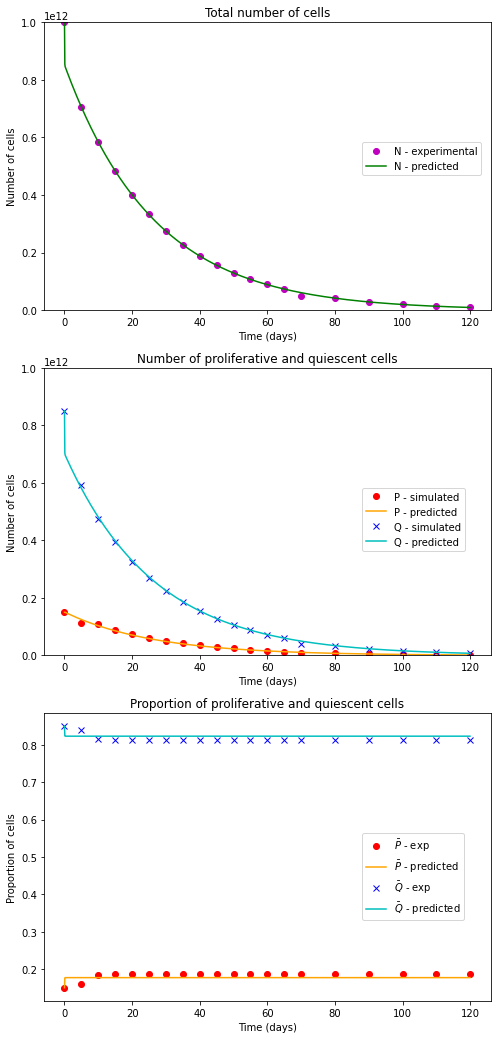

In [15]:
import numpy as np
from scipy import optimize
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd


def two_states_model(x, t, kPQ, kQP, uP, uQ):
    """
    this is the model to be fitted x[0] is P and x[1] is Q
    uP is the proliferation rate of proliferative cells P
    uQ is the death rate of quiscent cells Q
    kPQ and kQP are transition rates between the two phenotypes
    """
    dP = (uP - kPQ) * x[0] + kQP * x[1]
    dQ = (uQ - kQP) * x[1] + kPQ * x[0]

    return np.array([dP, dQ])


def negative_loglikelihood(x0, Pbar_exp, N_exp, time):
    """
        all inputs must be numpy arrays, if not please
        convert from pandas.DataFrame to numpy using
        the built-in function pandas.DataFrame.to_numpy()
    """
    P_exp = N_exp * Pbar_exp
    Q_exp = N_exp * (1 - Pbar_exp)

    predictions = odeint(two_states_model,
                         t=time,
                         y0=np.array([P_exp[0], Q_exp[0]]),
                         args=tuple(x0))

    N_predicted = predictions[:, 0] + predictions[:, 1]
    Pbar_predicted = predictions[:, 0] / N_predicted

    # print(Pbar_predicted)

    sumofsquares_Pbar = np.sum((Pbar_exp - Pbar_predicted) ** 2)
    sumofsquares_N = np.sum((N_exp - N_predicted) ** 2)

    sigma_Pbar = 0.1 #np.sqrt(sumofsquares_Pbar / 3)  # If fixed.
    ## Otherwise include as the last element in parameters_x and use the last line here instead
    sigma_N =  10000 #np.sqrt(sumofsquares_N / 3)

    negative_loglikelihood_Pbar = ( (len(Pbar_exp) - 1) / 2) * np.log(2 * np.pi * sigma_Pbar ** 2) + \
                                  sumofsquares_Pbar / (2 * sigma_Pbar ** 2)
    negative_loglikelihood_N = ( (len(N_exp) -1)/ 2) * np.log(2 * np.pi * sigma_N ** 2) + \
                               sumofsquares_N / (2 * sigma_N ** 2)


    total_loglikelihood = negative_loglikelihood_Pbar + negative_loglikelihood_N

    # print(kPQ)
    return total_loglikelihood


def find_global_minimum(patient, number_of_trials, seed=42):
    """
    this function runs the optimization for a patient several times (`number_of_trials`)
    keeping all estimated parameters in the array `parameters`
    and then converting to a pandas.DataFrame before outputing
    """

    np.random.seed(seed)

    columns = ["kPQ", "kQP", "uP", "uQ", "NegLogL"]

    parameters = np.zeros((number_of_trials, len(columns)))

    patient_id = patient_ids[patient]

    N_exp = df[df["patient"] == patient_id].sort_values(by="time")["number_of_cells"].to_numpy()

    time = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,80,90,100,110,120]) #20 data points
    #time = np.array([0,10,20,30,40,50,60,80,100,120])#10 data points
    #time = np.array([0,30,60,80,120])#5 data points

    Pbar_exp = df[df["patient"] == patient_id].sort_values(by="time")["Pbar"].to_numpy()

    #               kPQ,     kQP,      uP,      uQ
    all_bounds = ( (0, 300), (0, 100), (0, 100), (-300, 0))
    #all_bounds = ((0, None), (0, None), (0, 10), (0, 10), (-10, 10), (-10, 10))

    P0_exp = N_exp[0] * Pbar_exp[0]
    Q0_exp = N_exp[0] * (1 - Pbar_exp[0])
    for trial in range(number_of_trials):

        kPQ =  all_bounds[0][0] + all_bounds[0][1] * np.random.rand() 
        kQP = all_bounds[1][0] + all_bounds[1][1] * np.random.rand()
        uP = all_bounds[2][0] + all_bounds[2][1] * np.random.rand()
        uQ = all_bounds[3][0] * np.random.rand()
        #kPQ= 32.099
        #kQP= 62.082
        #uP=  11.472
        #uQ= -34.569
        
        
        x0 = np.array([kPQ, kQP, uP, uQ])

        res = optimize.minimize(fun=negative_loglikelihood,
                                x0=x0,
                                args=(Pbar_exp, N_exp, time),
                                bounds=all_bounds,
                                options={'disp': False},
                                method='L-BFGS-B')  # L-BFGS-B chosen automatically with bounds

        parameters[trial, :-1] = res.x
        parameters[trial, -1] = negative_loglikelihood(res.x,
                                                       Pbar_exp,
                                                       N_exp,
                                                       time)

    parameters = pd.DataFrame(data=parameters, columns=columns)

    return parameters


def optimize_all_patients(patient_ids, number_of_trials, seed=42):
    """
    this function will estimate parameters for all patients individually
    and return the best fit in a dataFrame
    """

    columns = ["patient", "kPQ", "kQP", "uP", "uQ", "NegLogL"]

    all_patients = np.zeros((len(patient_ids), len(columns)))

    for n, patient in enumerate(patient_ids):
        print("Finding parameters for patient number:", patient)

        parameters = find_global_minimum(n, number_of_trials, seed)
        best_fit = parameters[parameters["NegLogL"] == np.min(parameters["NegLogL"])].to_numpy()[0]

        all_patients[n, 0] = patient
        all_patients[n, 1:] = best_fit

    all_patients = pd.DataFrame(data = all_patients, columns = columns)
    return all_patients

df = pd.read_csv("20-points.csv")
#df = pd.read_csv("10-points.csv")
#df = pd.read_csv("5-points.csv")

patient_ids = df["patient"].unique()


# this estimates the parameters for all patients and returns it in a dataframe with
# the negative log likelihood
# to compute the AIC you need to sum up all the NegLogL
#all_patients = optimize_all_patients(patient_ids, number_of_trials = 10, seed=42)

# optimize intra cluster
# case 11 (patient id 80) is problematic
#cluster = [67, 68]
#parameters = find_global_minimum_per_cluster(patient_list=cluster, number_of_trials=50, seed=42)

### per patient estimation
import time as timeLib

start = timeLib.time()
# possible parameters to tune
# sigma_N and sigma_Pbar, inside the loglikehood function
# number_of_trials

patient = 0# select a patient
parameters = find_global_minimum(patient=patient, number_of_trials=500, seed=42)

end = timeLib.time()

print(end - start)  # this how long the optimization ran

parameters = parameters.dropna()

# gets the fit with the lowest minLog(likelihood)
best_fit = parameters[parameters["NegLogL"] == np.min(parameters["NegLogL"])].to_numpy()[0][:-1]
P0 = df[(df["patient"]==patient_ids[patient]) & (df["time"]==0)].sort_values(by="time")["P"].to_numpy()[0]
Q0 = df[(df["patient"]==patient_ids[patient]) & (df["time"]==0)].sort_values(by="time")["Q"].to_numpy()[0]

predictions = odeint(two_states_model,
                     t=np.arange(0, 120, 0.1),
                     y0=np.array([P0, Q0]),
                     args=tuple(best_fit))



Pbar_predicted = predictions[:, 0] / (predictions[:, 0] + predictions[:, 1])

time = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,80,90,100,110,120]) #20 data points
    #time = np.array([0,10,20,30,40,50,60,80,100,120])#10 data points
    #time = np.array([0,30,60,80,120])#5 data points

patient_id = patient_ids[patient]

Pbar_exp = df[df["patient"] == patient_id].sort_values(by="time")["Pbar"].to_numpy()
N_exp = df[df["patient"] == patient_id].sort_values(by="time")["number_of_cells"].to_numpy()


#fitting total number of cells
fig = plt.figure(figsize=(8,18))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(time, N_exp, "mo", label="N - experimental")
scale_factor = 1e12
#xmin, xmax = plt.xlim()
#ymin, ymax = plt.ylim()
ax1.set_ylim([0, 1 * scale_factor])
#ax1.set_ylim([0,1e12])
ax1.set_xlabel("Time (days)")
ax1.plot(np.arange(0, 120, 0.1), predictions[:, 0] + predictions[:, 1], label="N - predicted",color="green")
ax1.set_ylabel("Number of cells")
ax1.set_title("Total number of cells")
ax1.legend(bbox_to_anchor=(0.7, 0.6), loc='upper left')


#Fitting of the numbers of proliferative and quiescence cells
ax2 = fig.add_subplot(3,1,2)
ax2.plot(time, Pbar_exp*N_exp, "ro", label="P - simulated")
ax2.plot(np.arange(0, 120, 0.1), predictions[:, 0], label="P - predicted",color="orange")
ax2.plot(time, (1-Pbar_exp)*N_exp, "bx", label="Q - simulated",)
ax2.plot(np.arange(0, 120, 0.1), predictions[:, 1], label="Q - predicted",color="c")
scale_factor = 1e12
#xmin, xmax = plt.xlim()
#ymin, ymax = plt.ylim()
ax2.set_ylim([0, 1 * scale_factor])
#ax2.set_ylim([0,1e12])
ax2.set_xlabel("Time (days)")
ax2.set_ylabel("Number of cells")
ax2.set_title("Number of proliferative and quiescent cells")
ax2.legend(bbox_to_anchor=(0.7, 0.6), loc='upper left')


# Fitting proportion of proliferative and quiescence cells
ax3 = fig.add_subplot(3,1,3)
ax3.plot(time, Pbar_exp, "ro", label=r"$\bar{P}$ - exp")
ax3.plot(np.arange(0, 120, 0.1), Pbar_predicted, label=r"$\bar{P}$ - predicted",color='orange')
ax3.plot(time, 1 - Pbar_exp, "bx", label=r"$\bar{Q}$ - exp")
ax3.plot(np.arange(0, 120, 0.1), 1 - Pbar_predicted, label=r"$\bar{Q}$ - predicted",color='c')
ax3.set_xlabel("Time (days)")
ax3.set_ylabel("Proportion of cells")
ax3.set_title("Proportion of proliferative and quiescent cells")
ax3.legend(bbox_to_anchor=(0.7, 0.6), loc='upper left')


fig.savefig('plot_20.pdf')

In [1]:
#fig.savefig('plot3.pdf')

In [2]:
#best_fit